# Requirements

In [1]:
import itertools
import math
import matplotlib.pyplot as plt
%matplotlib inline
from numba import cuda, njit, vectorize
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import numpy as np
import random

# Simple example

In [2]:
def gaussian_pure(x, μ, σ):
    if type(x) == float:
        return math.exp(-0.5*((x - μ)/σ)**2)/(σ*math.sqrt(2.0*math.pi))
    else:
        return list(map(lambda x: math.exp(-0.5*((x - μ)/σ)**2)/(σ*math.sqrt(2.0*math.pi)), x))

In [3]:
x = np.linspace(-10.0, 10.0, 1_000_000, dtype=np.float32)
μ = np.float32(0.0)
σ = np.float32(1.0)

In [4]:
%timeit gaussian_pure(x, μ, σ)

2.51 s ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
@vectorize(['float32(float32, float32, float32)'])
def gaussian(x, μ, σ):
    return math.exp(-0.5*((x - μ)/σ)**2)/(σ*math.sqrt(2.0*math.pi))

In [6]:
%timeit gaussian(x, μ, σ)

6.48 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_gpu(x, μ, σ):
    return math.exp(-0.5*((x - μ)/σ)**2)/(σ*math.sqrt(2.0*math.pi))

In [8]:
%timeit gaussian_gpu(x, μ, σ)

3.03 ms ± 615 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
x_dev = cuda.to_device(x)
values = cuda.device_array_like(x)

In [10]:
%timeit gaussian_gpu(x_dev, μ, σ, out=values)

798 µs ± 16 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
def gaussian_np(x, μ, σ):
    return np.exp(-0.5*((x - μ)/σ)**2)/(σ*np.sqrt(2.0*np.pi))

In [12]:
%timeit gaussian_np(x, μ, σ)

1.04 ms ± 9.71 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
pure_values = list(gaussian_pure(x, μ, σ))
values = gaussian(x, μ, σ)
gpu_values = gaussian_gpu(x, μ, σ)
np_values = gaussian_np(x, μ, σ)
(np.allclose(values, gpu_values),
    np.allclose(values, np_values),
    np.allclose(values, pure_values)
)

(True, True, True)

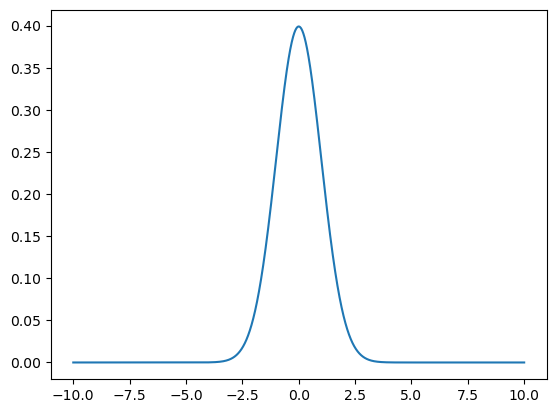

In [14]:
_ = plt.plot(x, pure_values)

# Computing $\pi$

We compute $\pi$ by throwing darts at a square and counting how many land in an inscribed circle.

## CPU implementation

In [15]:
@njit
def compute_pi_cpu(nr_tries):
    hits = 0
    for _ in range(nr_tries):
        x = random.random()
        y = random.random()
        if x**2 + y**2 < 1.0:
            hits += 1
    return 4.0*hits/nr_tries

In [16]:
compute_pi_cpu(100_000)

3.14204

## Precision

Just out of curiosity, what precision can we expect as a function of the number of darts?

In [17]:
def assess_precision(compute_pi, start_exp, stop_exp, nr_runs=5, *args):
    all_nr_tries = np.logspace(start_exp, stop_exp, num=stop_exp - start_exp + 1, dtype=np.int64)
    results = np.empty(shape=(all_nr_tries.size*nr_runs, 2))
    result_nr = 0
    for nr_tries in all_nr_tries:
        for _ in range(nr_runs):
            pi = compute_pi(nr_tries, *args)
            results[result_nr, :] = nr_tries, np.abs(pi - np.pi)/np.pi
            result_nr += 1
    return results

In [18]:
precisions = assess_precision(compute_pi_cpu, 2, 9, 5)

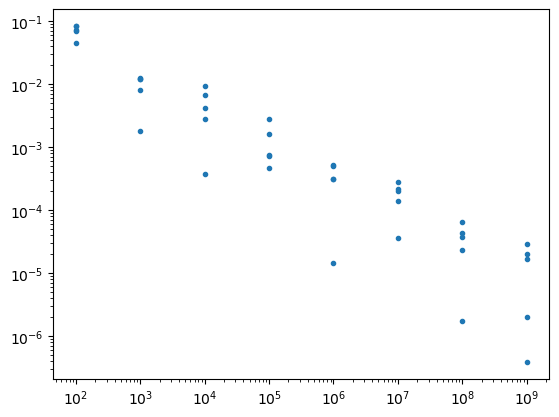

In [19]:
_ = plt.loglog(precisions[:, 0], precisions[:, 1], '.')

The precision increases, but not as fast as you might hope.

We want to compare the performance of the version that runs on CPU with the one on GPU, so we will define the number of tries in terms of number of blocks and number of threads per block, although that is not relevant for the CPU version.

In [20]:
nr_blocks = 4096
nr_threads_per_block = 128
nr_tries = 1024*nr_blocks*nr_threads_per_block

In [21]:
%timeit compute_pi_cpu(nr_tries)

3.25 s ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## GPU implementation

Since this requires a random number generator, we use the numba GPU random number generator `xoroshiro128p_uniform_float32`.

In [22]:
@cuda.jit
def compute_pi_kernel(rng_states, nr_tries, result):
    idx = cuda.grid(1)
    hits = 0
    for _ in range(nr_tries):
        x = xoroshiro128p_uniform_float32(rng_states, idx)
        y = xoroshiro128p_uniform_float32(rng_states, idx)
        if x**2 + y**2 < 1.0:
            hits += 1
    result[idx] = 4.0*hits/nr_tries

It would be useful to have a wrapper function, since some scaffolding is required to use this kernel.

In [23]:
def compute_pi_gpu(nr_tries, nr_blocks, nr_threads_per_blocks):
    rng_states = create_xoroshiro128p_states(nr_blocks*nr_threads_per_block,
                                             seed=random.randint(0, 100_000))
    dev_result = cuda.device_array((nr_blocks*nr_threads_per_block, ),
                                   dtype=np.float32)
    compute_pi_kernel[nr_blocks, nr_threads_per_block](
        rng_states,
        nr_tries//(nr_blocks*nr_threads_per_block),
        dev_result
    )
    cuda.synchronize()
    return np.sum(dev_result)/dev_result.shape[0]

In [24]:
compute_pi_gpu(nr_tries, nr_blocks, nr_threads_per_block)

3.141540050506592

In [25]:
%timeit compute_pi_gpu(nr_tries, nr_blocks, nr_threads_per_block)

119 ms ± 870 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


It is clear that the GPU version is significantly faster.

In [26]:
precisions = assess_precision(compute_pi_gpu, 2, 9, 5, nr_blocks, nr_threads_per_block)

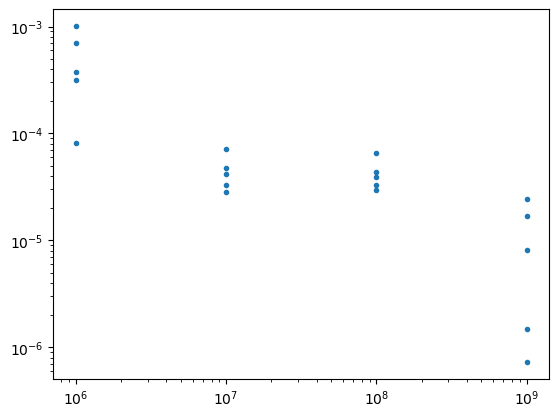

In [27]:
_ = plt.loglog(precisions[:, 0], precisions[:, 1], '.')

# Mandelbrot set

As for many of the other approeaches, we will consider the generation of the Mandelbrot set once more.

It can be easily implemented as a CUDA kernel using the numba library and specifying `cuda` as a target for the `vectorize` decorator.  We specify the signature of the function, using single precision copmlex numbers and unsigned 8-bit integers as return type.

In [28]:
@vectorize(['uint8(complex64, complex64, int32)'], target='cuda')
def mandelbrot(z, c, max_steps):
    nr_steps = 0
    while z.real**2 + z.imag**2 < 4.0 and nr_steps < max_steps:
        z = z**2 + c
        nr_steps += 1
    return nr_steps

Now we can generate the input complex numbers as a 2D array.

In [29]:
n = 1_000
x = np.linspace(-1.8, 1.8, n, dtype=np.float32)
y = np.linspace(-1.8, 1.8, n, dtype=np.float32)
X, Y = np.meshgrid(x, y)
z = X + 1.0j*Y

Verify that the type of `z` is as expected, i.e., single precision complex.

In [30]:
z.dtype

dtype('complex64')

In [31]:
z.shape

(1000, 1000)

Define the other input values `c` and `max_steps`.

In [32]:
c = np.complex64(0.4 + 0.6j)
max_steps = np.int32(256)

Do the computation on the device.

In [33]:
image = mandelbrot(z, c, max_steps)

The resulting data type is numpy array on the host, and its type is unsigned 8-bit as specified.

In [34]:
type(image)

numpy.ndarray

In [35]:
image.dtype

dtype('uint8')

In [36]:
image.shape

(1000, 1000)

We can visualize the result using matplotlib.

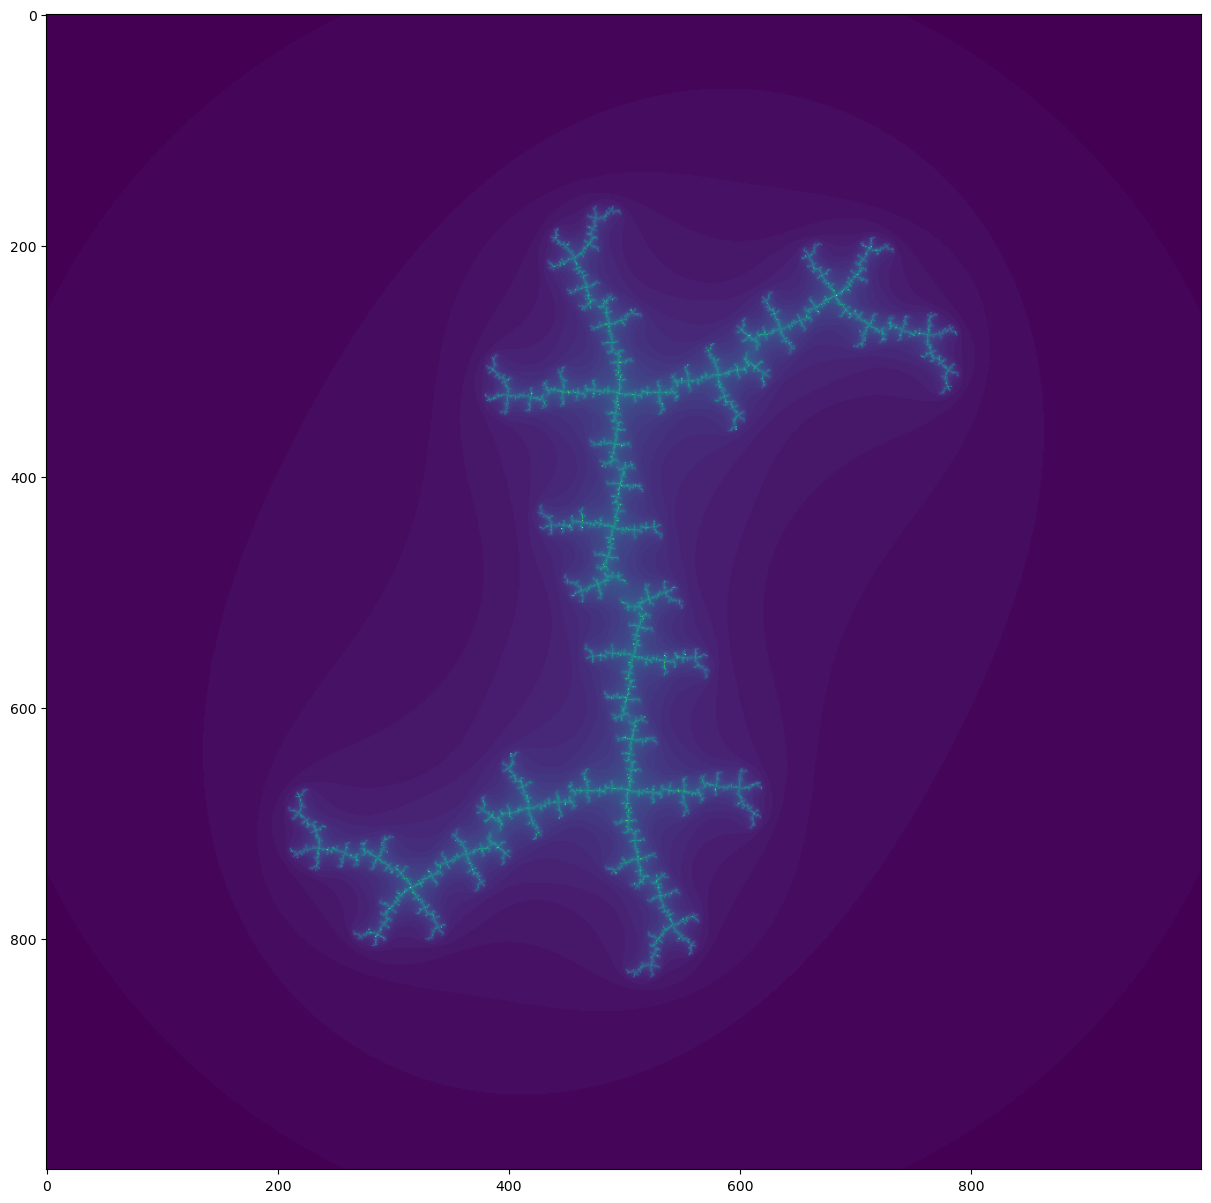

In [37]:
figure, axes = plt.subplots(figsize=(15, 15))
axes.set_aspect('equal')
_ = axes.imshow(image)

Compared to pyCUDA, using numba is considerably easier.

## Benchmarks

Let's compare the performance of numba on CPU and GPU.

In [38]:
@vectorize(['uint8(complex64, complex64, int32)'])
def mandelbrot_cpu(z, c, max_steps):
    nr_steps = 0
    while z.real**2 + z.imag**2 < 4.0 and nr_steps < max_steps:
        z = z**2 + c
        nr_steps += 1
    return nr_steps

In [39]:
@vectorize(['uint8(complex64, complex64, int32)'], target='cuda')
def mandelbrot_gpu(z, c, max_steps):
    nr_steps = np.uint8(0)
    while z.real*z.real + z.imag*z.imag < 4.0 and nr_steps < max_steps:
        z = z*z + c
        nr_steps += 1
    return nr_steps

In [40]:
n = 10_000
x = np.linspace(-1.8, 1.8, n, dtype=np.float32)
y = np.linspace(-1.8, 1.8, n, dtype=np.float32)
X, Y = np.meshgrid(x, y)
z = X + 1.0j*Y

In [41]:
c = np.complex64(0.4 + 0.6j)
max_steps = np.int32(256)

In [42]:
%timeit mandelbrot_cpu(z, c, max_steps)

683 ms ± 7.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
%timeit mandelbrot_gpu(z, c, max_steps)

552 ms ± 67.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
z_dev = cuda.to_device(z)
image = cuda.device_array(shape=z.shape, dtype=np.uint8)

In [45]:
%timeit mandelbrot_gpu(z_dev, c, max_steps, out=image)

353 ms ± 49.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


However, the performance is not particularly impressive.

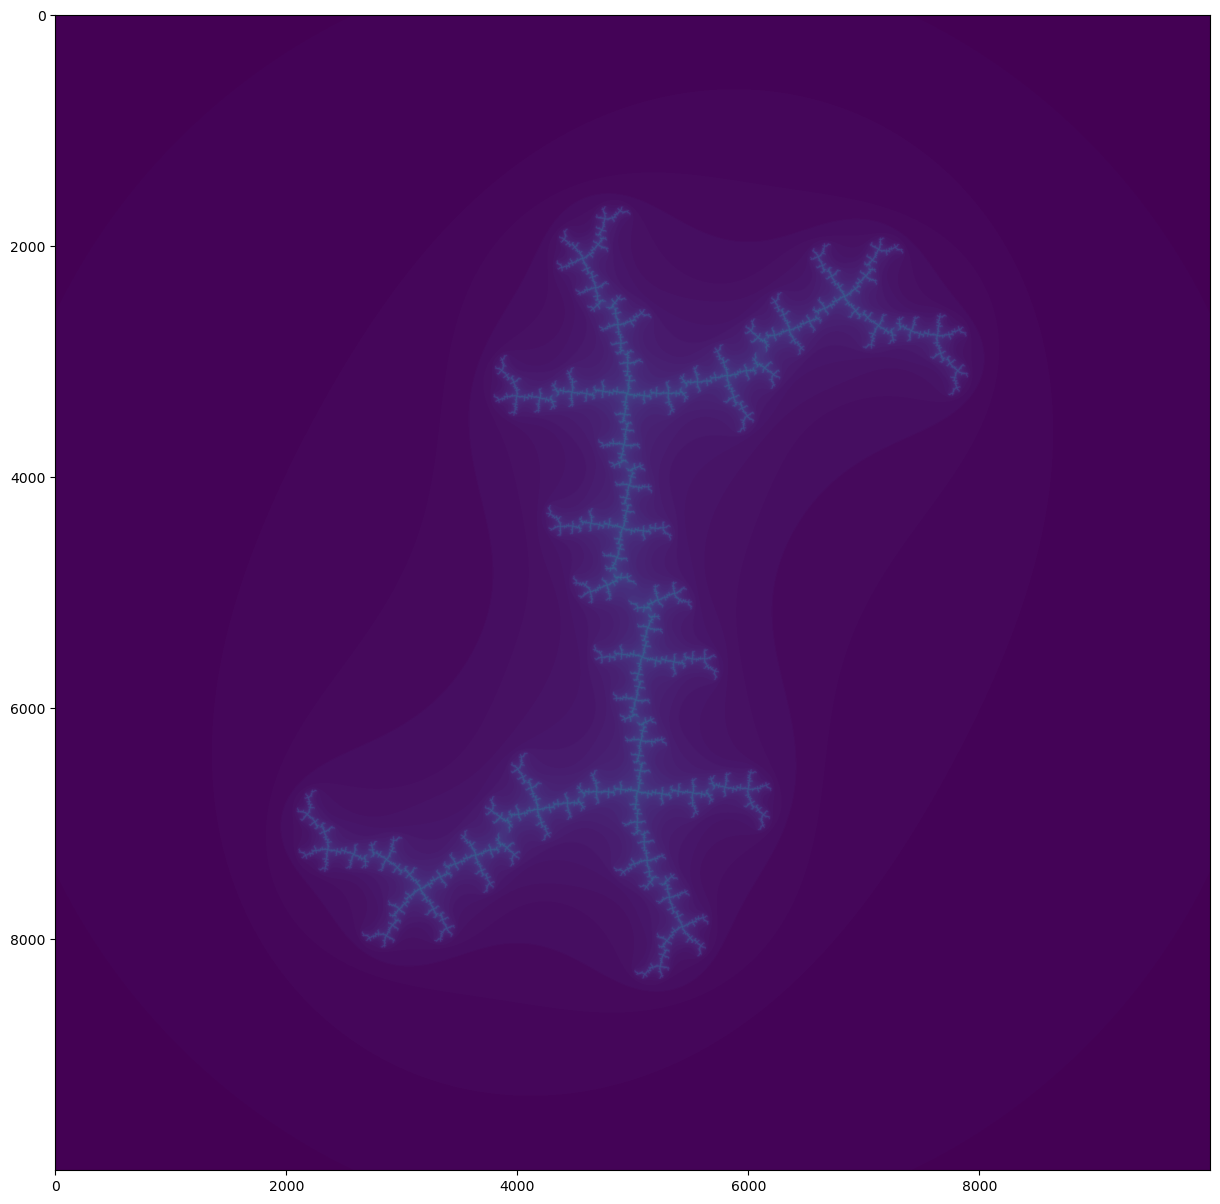

In [46]:
figure, axes = plt.subplots(figsize=(15, 15))
axes.set_aspect('equal')
_ = axes.imshow(image.copy_to_host())

## Grid stride loops

In [47]:
@cuda.jit
def mandelbrot_kernel(Z, c, max_steps, nr_steps):
    x, y = cuda.grid(2)
    x_stride, y_stride = cuda.gridsize(2)
    for i in range(x, Z.shape[0], x_stride):
        for j in range(y, Z.shape[1], y_stride):
            nr_steps[i][j] = 0
            z = Z[i][j]
            while (z.real*z.real + z.imag*z.imag < np.float32(4.0) and
                   nr_steps[i][j] < max_steps):
                z = z*z + c
                nr_steps[i][j] += 1

In [48]:
nr_blocks = 512
nr_threads_per_dim = 16
nr_threads_per_block = nr_threads_per_dim**2

In [49]:
n = nr_blocks*nr_threads_per_dim
x = np.linspace(-1.8, 1.8, n, dtype=np.float32)
y = np.linspace(-1.8, 1.8, n, dtype=np.float32)
X, Y = np.meshgrid(x, y)
z = X + 1.0j*Y

In [50]:
n

8192

In [51]:
c = np.complex64(0.4 + 0.6j)
max_steps = np.int32(256)

In [52]:
dev_z = cuda.to_device(z)
result = np.zeros(z.shape, dtype=np.uint8)
dev_result = cuda.to_device(result)

In [53]:
mandelbrot_kernel[nr_blocks, nr_threads_per_block](dev_z, c, max_steps,
                                                   dev_result)

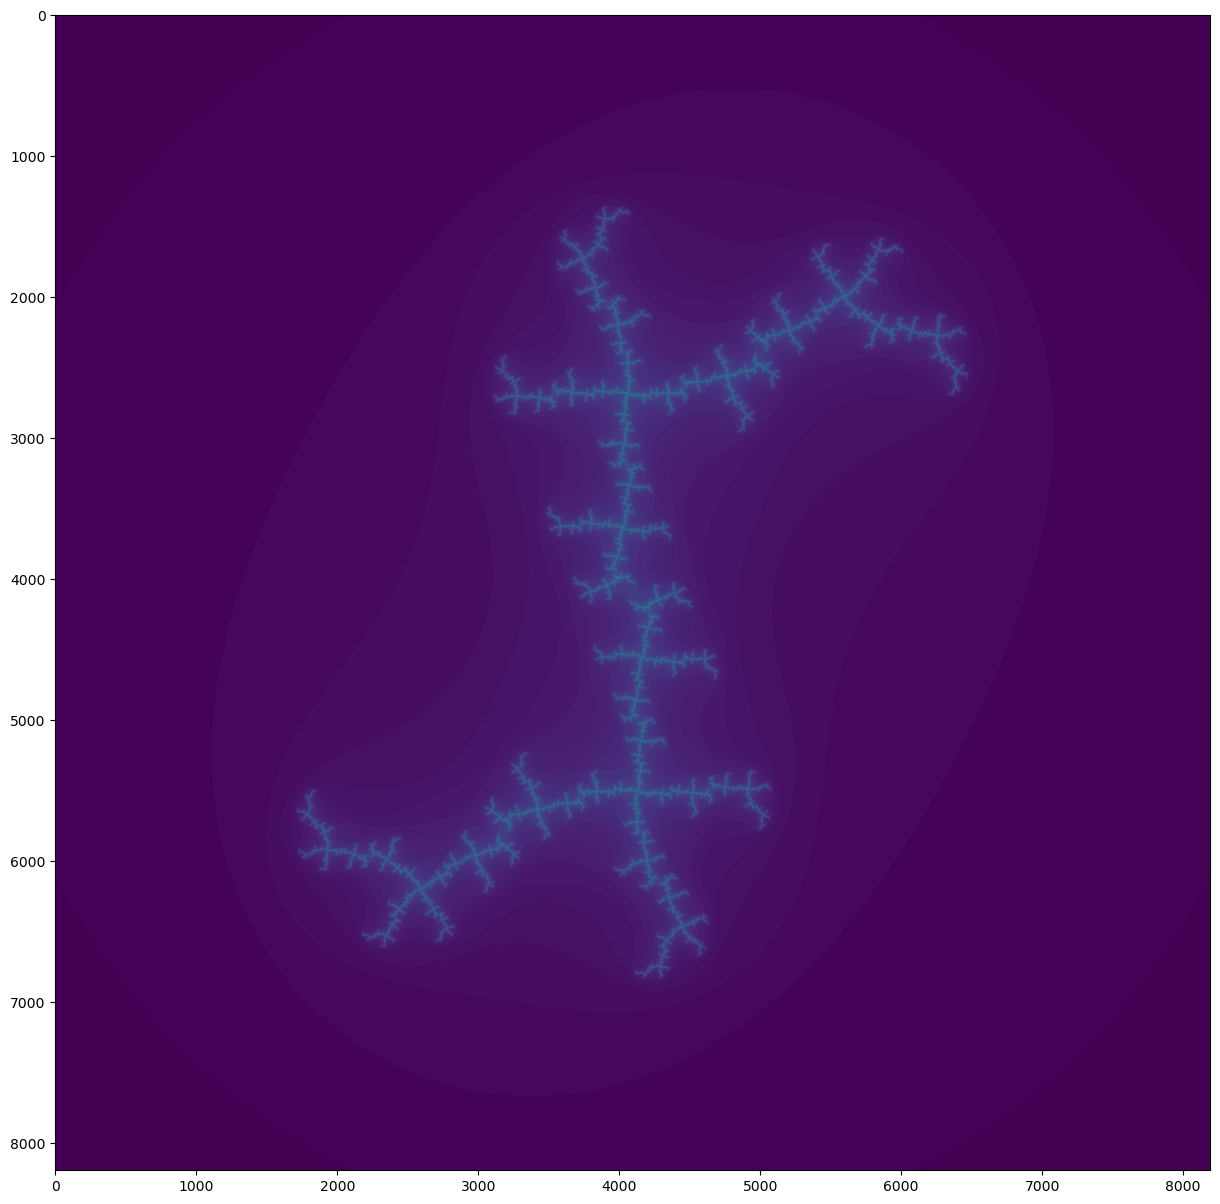

In [54]:
figure, axes = plt.subplots(figsize=(15, 15))
axes.set_aspect('equal')
_ = axes.imshow(dev_result.copy_to_host())

In [55]:
%timeit mandelbrot_kernel[nr_blocks, nr_threads_per_block](dev_z, c, max_steps, dev_result); cuda.synchronize()

16.3 ms ± 70.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [56]:
%timeit mandelbrot_cpu(z, c, max_steps)

456 ms ± 4.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Giving threads more work improves the performance by a factor of 15.

## Coalescing memory

However, the memory access pattern is suboptimal.  It can be improved by ensuring that the threads in a warp use data that is on the same cache line.  The 2D array 1z1 is stored row wise, so  the 32 threads will use 32 consecutive values when the array is traversed if the row index changes faster.  This memory access pattern is called coalesced in GPU-speak.

In [57]:
@cuda.jit
def mandelbrot_coalesced_kernel(Z, c, max_steps, nr_steps):
    x, y = cuda.grid(2)
    x_stride, y_stride = cuda.gridsize(2)
    for i in range(x, Z.shape[0], x_stride):
        for j in range(y, Z.shape[1], y_stride):
            nr_steps[j][i] = 0
            z = Z[j][i]
            while (z.real*z.real + z.imag*z.imag < np.float32(4.0) and
                   nr_steps[j][i] < max_steps):
                z = z*z + c
                nr_steps[j][i] += 1

In [58]:
%timeit mandelbrot_coalesced_kernel[nr_blocks, nr_threads_per_block](dev_z, c, max_steps, dev_result); cuda.synchronize()

The slowest run took 7.38 times longer than the fastest. This could mean that an intermediate result is being cached.
38.3 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Thanks to coalesced memory access, the performance is again improved.

# Data mapping

We can explore the mapping of data on blocks by assigning the block index to an array element.

In [59]:
@cuda.jit
def map_2d_kernel(A):
    idx = cuda.grid(1)
    x, y = cuda.grid(2)
    A[x, y] = idx

In [60]:
A = np.zeros((16, 16), dtype=np.int32)
nr_blocks = (1, 1)
nr_threads_per_block = (16, 16)

In [61]:
map_2d_kernel[nr_blocks, nr_threads_per_block](A)

/home/gjb/mambaforge/envs/python_on_gpus/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/gjb/mambaforge/envs/python_on_gpus/lib/python3.11/site-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [62]:
A

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
       [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
       [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
       [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
       [ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
       [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,

# Row versus column sum and memory access

In [63]:
n = 2**14
nr_threads_per_block = 128
nr_blocks = n//nr_threads_per_block

In [64]:
nr_blocks

128

In [65]:
A = np.random.uniform(size=(n, n)).astype(np.float32)
A_dev = cuda.to_device(A)
sums = np.zeros((n, ), dtype=np.float32)
sums_dev = cuda.to_device(sums)

In [66]:
@cuda.jit
def row_sum_kernel(A, sums):
    idx = cuda.grid(1)
    row_sum = 0.0
    for j in range(A.shape[1]):
        row_sum += A[idx][j]
    sums[idx] = row_sum

In [67]:
row_sum_kernel[nr_blocks, nr_threads_per_block](A_dev, sums_dev)

In [68]:
cuda.synchronize()

In [69]:
sums_dev.copy_to_host()

array([8139.4727, 8234.009 , 8195.299 , ..., 8259.997 , 8180.0547,
       8258.84  ], dtype=float32)

In [70]:
%timeit row_sum_kernel[nr_blocks, nr_threads_per_block](A_dev, sums_dev); cuda.synchronize()

10.2 ms ± 20.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [71]:
@cuda.jit
def col_sum_kernel(A, sums):
    idx = cuda.grid(1)
    col_sum = 0.0
    for i in range(A.shape[0]):
        col_sum += A[i][idx]
    sums[idx] = col_sum

In [72]:
col_sum_kernel[nr_blocks, nr_threads_per_block](A_dev, sums_dev)

In [73]:
sums_dev.copy_to_host()

array([8172.301 , 8172.223 , 8154.5977, ..., 8204.726 , 8185.384 ,
       8170.921 ], dtype=float32)

In [74]:
%timeit col_sum_kernel[nr_blocks, nr_threads_per_block](A_dev, sums_dev); cuda.synchronize()

6.48 ms ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Device functions

Device functions can be easily defined using the optional `device` argument in the decorator.  Such functions can only be called from kernels or other device functions, never from the host.

In [75]:
@cuda.jit(device=True)
def distance_dev(a, b):
    return math.sqrt(a**2 + b**2)

In [76]:
candidates = np.array(list(itertools.permutations(range(1, 10))),
                      dtype=np.int64)

In [77]:
nr_threads_per_block = 128
n = 10_000*nr_threads_per_block
a = np.random.uniform(size=n).astype(np.float32)
b = np.random.uniform(size=n).astype(np.float32)
expected = np.sqrt(a**2 + b**2)
out = np.empty_like(a)

In [78]:
@cuda.jit
def distance_kernel(a, b, out):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    for i in range(start, a.shape[0], stride):
        out[i] = distance_dev(a[i], b[i])

In [79]:
distance_kernel[nr_blocks, nr_threads_per_block](a, b, out)

/home/gjb/mambaforge/envs/python_on_gpus/lib/python3.11/site-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [80]:
np.testing.assert_almost_equal(out, expected)